<a href="https://colab.research.google.com/github/vijayc9/Movie-Recommendation-System/blob/main/Recomendation_System_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Download The dataset

In [102]:
# link to download: https://www.kaggle.com/grouplens/movielens-20m-dataset
# Over 20 Million Movie Ratings and Tagging
path = "/content/drive/MyDrive/Colab Notebooks/RecommenderSystem_MovieLens/MovieLens_Data/"
movies = pd.read_csv(path+"movie.csv")
tags = pd.read_csv(path+"tag.csv")
ratings = pd.read_csv(path+"rating.csv")

## Data Preprocessing and EDA

In [109]:
# Looking into ratings dataframe

print(ratings.head())
print('\n\nNumber of ratings                            : ', ratings.shape[0])
print('Number of users who rated at least one movie : ', ratings['userId'].nunique())
print('Number of movies with at least one rating    : ', ratings['movieId'].nunique())
print('Max rating: ', ratings['rating'].max(), '\t\t Min rating: ', ratings['rating'].min())

   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


Number of ratings                            :  20000263
Number of users who rated at least one movie :  138493
Number of movies with at least one rating    :  26744
Max rating:  5.0 		 Min rating:  0.5


**20 Millions ratings**!!

In [113]:
# Looking into movies dataframe

print(movies.head(2))
print('\n\nNumber of movies with at least one rating : ', ratings['movieId'].nunique())
print('Number of movies                          : ', movies['movieId'].nunique())


   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy


Number of movies with at least one rating :  26744
Number of movies                          :  27278


Some Movies have not been rated!!

In [117]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
interaction_mat_size = n_users*n_movies
print("user_item_matrix size: ", n_users*n_movies/1000000000, "Billon")
interaction_count = ratings.shape[0]
sparsity = 1 - (interaction_count / interaction_mat_size)
print("Dataset sparsity     : ", sparsity)


## user-item matrix size is very Huge and it is Very Sparse

user_item_matrix size:  3.703856792 Billon
Dataset sparsity     :  0.9946001521864456


**user-item matrix** size is very **Huge** and it is Very **Sparse**

### **Creating a dataframe of no_of_users who have watched a movie and average ratings recieved by that movie**

In [119]:
# Create a DataFrame of average ratings on each movie 

ratings_expanded = pd.merge(ratings, movies, on="movieId")
avg_movie_ratings = pd.DataFrame(ratings_expanded.groupby("title").mean()['rating'])
avg_movie_ratings['rating_count'] = pd.DataFrame(ratings_expanded.groupby("title").count()["rating"])
avg_movie_ratings.head()

,rating,rating_count
title,,
#chicagoGirl: The Social Network Takes on a Dictator (2013),3.666667,3
$ (Dollars) (1971),2.833333,24
$5 a Day (2008),2.871795,39
$9.99 (2008),3.009091,55
$ellebrity (Sellebrity) (2012),2.000000,2


In [120]:
avg_movie_ratings.shape

(26729, 2)

In [152]:
avg_movie_ratings.describe()

,rating,rating_count
count,26729.000000,26729.000000
mean,3.133277,748.260803
std,0.664123,3086.673456
min,0.500000,1.000000
25%,2.800000,3.000000
50%,3.235529,18.000000
75%,3.565217,205.000000
max,5.000000,67310.000000


Text(0.5, 6.800000000000011, 'average rating recieved for a movie')

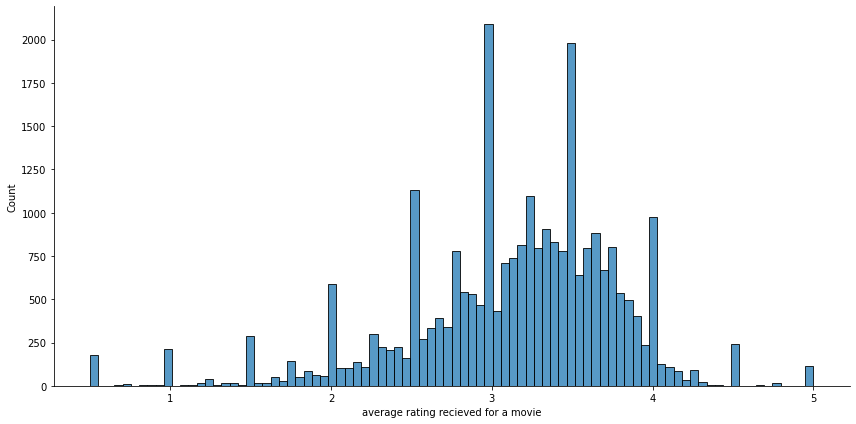

In [138]:
# Checking the ratings histogram

import seaborn as sns
sns.displot(data=avg_movie_ratings, x="rating", height=6, aspect=2)
plt.xlabel("average rating recieved for a movie")

From Graph we see that Movies tend to have higher ratings on average

Text(0.5, 6.800000000000011, 'No_of_ratings a movie has')

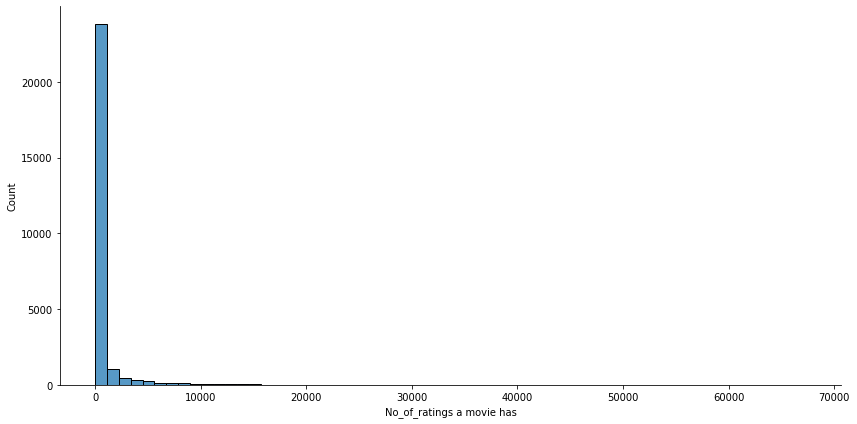

In [136]:
# Checking the number_of_ratings histogram

import seaborn as sns
sns.displot(data=avg_movie_ratings, x="rating_count", bins=60, height=6, aspect=2)
plt.xlabel("No_of_ratings a movie has")

We see that majority of movies have just a few ratings!

### **Creating a dataframe of no_of_movies watched by a user and average ratings given by that user**

In [147]:
# Creating the dataframe

avg_user_ratings = pd.DataFrame(ratings.groupby("userId").mean()['rating'])
avg_user_ratings['rating_count'] = pd.DataFrame(ratings.groupby("userId").count()["rating"])
avg_user_ratings.head()

,rating,rating_count
userId,,
1,3.742857,175
2,4.000000,61
3,4.122995,187
4,3.571429,28
5,4.272727,66


In [148]:
avg_user_ratings.shape

(138493, 2)

In [151]:
avg_user_ratings.describe()

,rating,rating_count
count,138493.000000,138493.000000
mean,3.627209,144.413530
std,0.443030,230.267257
min,0.500000,20.000000
25%,3.369478,35.000000
50%,3.653846,68.000000
75%,3.923077,155.000000
max,5.000000,9254.000000


Text(0.5, 6.800000000000011, 'average rating given by a user')

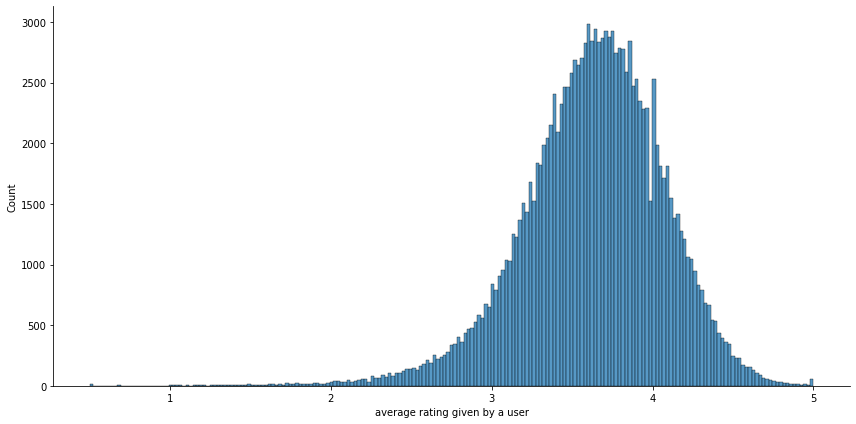

In [149]:
# Checking the ratings histogram

import seaborn as sns
sns.displot(data=avg_user_ratings, x="rating", height=6, aspect=2)
plt.xlabel("average rating given by a user")

Text(0.5, 6.800000000000011, 'No_of_ratings a user has given')

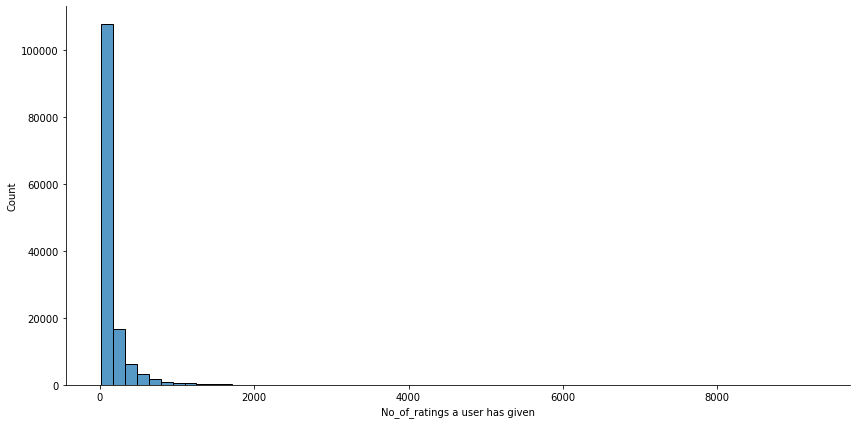

In [150]:
# Checking the number_of_ratings histogram

import seaborn as sns
sns.displot(data=avg_user_ratings, x="rating_count", bins=60, height=6, aspect=2)
plt.xlabel("No_of_ratings a user has given")

From graph it is observed that **user and movie behave similar**


  
*   average rating received by a movie is around 3.4, so is the average rating given by an user
*   Very few movies have been seen by a lot no of people, so is the case that very few people have seen a lot no of movies



## Feature Engineering

In [61]:
user_n = len(ratings.userId.unique())
movie_n= len(ratings.movieId.unique())
print("unique users: ", user_n)
print("unique movies: ", movie_n)
print("Total no of entry in user_item matrix: {} Billion entries".format(user_n*movie_n/1000000000))

unique users:  138493
unique movies:  26744
Total no of entry in user_item matrix: 3.703856792 Billion entries


This is a huge dataset of **3.7B entries**!!!!!!, so we need to reduce user and movies otherwise our system may crash.... 



In [62]:
# Reducing user
# Taking only those users who have seen more than 500 movies

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 500)
print('user % retained: ',len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100)
print('Total no of users after reduction: ', len(ratings_f.userId.unique()))

user % retained:  5.40893763583719
Total no of users after reduction:  7491


In [63]:
# Reducing movies
# Taking only those movies which have been seen by more than 500 users

ratings_f = ratings_f.groupby('movieId').filter(lambda x: len(x) >= 500)
print("movies % retained: ",len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100)
print('Total no of movies after reduction: ', len(ratings_f.movieId.unique()))

movies % retained:  11.503775936652247
Total no of movies after reduction:  3138


In [64]:
# Filter the movie dataFrame 
movies_f = movies[movies.movieId.isin(ratings_f.movieId.tolist())]

## **popularity based recomendation:** based on Most_viewed and Top_rated movies

In [65]:
# Create a new DataFrame with popular movies and their ratings
ratings_expanded = pd.merge(ratings_f, movies_f, on="movieId")
avg_movies_ratings = pd.DataFrame(ratings_expanded.groupby("title").mean()['rating'])
avg_movies_ratings['rating_count'] = pd.DataFrame(ratings_expanded.groupby("title").count()["rating"])
movies_most_viewed = avg_movies_ratings.sort_values(by='rating_count', ascending=False)
movies_top_rated = avg_movies_ratings.sort_values(by='rating', ascending=False)

In [66]:
movies_most_viewed.head()

,rating,rating_count
title,,
"Matrix, The (1999)",4.146633,6980
Forrest Gump (1994),3.844184,6912
Jurassic Park (1993),3.603232,6868
Back to the Future (1985),3.933168,6853
Pulp Fiction (1994),4.256348,6813


In [67]:
movies_top_rated.head()

,rating,rating_count
title,,
"Godfather, The (1972)",4.402116,5813
"Shawshank Redemption, The (1994)",4.376952,6469
Band of Brothers (2001),4.336177,879
"Usual Suspects, The (1995)",4.289315,6130
"Godfather: Part II, The (1974)",4.288553,4857


Save the top_viewed and most_rated movies to drive(so that we can directly load it whenever needed, no need to retrain the model again and again)

In [68]:
movies_most_viewed.to_csv(path+"movies_most_viewed.csv")
movies_top_rated.to_csv(path+"movies_top_rated.csv")

## **Content based Filtering** : converting each movie to a feature vecter, using the contents present in each movie

In [69]:
movies_f.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [70]:
# We can use 'genres' as one of the feature for featurization
# Convert genres into standard form
movies_f['genres'] = movies_f['genres'].str.replace('|',' ')
movies_f.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


Is there any other features of the movie which we can use for featurization

In [71]:
tags.head(2)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18


Users have also given a tag for movies, so we can use this information

In [72]:
# Create a mixed dataFrame of movies containing genres and tags 
movie_genre_tag = pd.merge(movies_f, tags, on='movieId', how='left')
movie_genre_tag.head(3)


,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched,2014-12-04 23:44:40
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation,2007-07-08 13:59:15
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature,2007-07-08 22:21:47


we can use genres and tags as a feature for each movie, and each movie can be represented by a feature vector for content based filtering

In [73]:
# In movie_genre_tag, for each movieId there are multiple tags, so combine them

# (movie_genre_tag.isnull().sum()) is not zero so,
# Tackle the entries containing null/NA 
movie_genre_tag.fillna("", inplace=True)

movie_genre_tag = pd.DataFrame(movie_genre_tag.groupby('movieId')['tag'].apply(lambda x: '%s' % ' '.join(x)))
movie_genre_tag = pd.merge(movies_f, movie_genre_tag, on='movieId', how='left')
movie_genre_tag.head(2)

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...


In [74]:
# genres and tags both contains text data, so combine them into one feature

movie_genre_tag['metadata'] = movie_genre_tag[['genres', 'tag']].apply(lambda x:' '.join(x), axis=1)
movie_genre_tag.head(2)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy time travel adapted...


In [75]:
# drop unnecessary features

final_movie_content = movie_genre_tag.drop(['genres', 'tag'], axis=1)
final_movie_content.head() 

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy time travel adapted...
2,3,Grumpier Old Men (1995),Comedy Romance old people that is actually fun...
3,4,Waiting to Exhale (1995),Comedy Drama Romance chick flick revenge chara...
4,5,Father of the Bride Part II (1995),Comedy Diane Keaton family sequel Steve Martin...


In [19]:
final_movie_content.shape

(3138, 3)

**NLP:** for text data processing

Using **tf-idf** for converting text data to vector form

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(final_movie_content['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=final_movie_content.index.tolist())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14989,14990,14991,14992,14993,14994,14995,14996,14997,14998
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dimensionaly of dataset is very large**, so we need to do dimensionality reduction

**SVD:** for dimensionality reduction

In [77]:
# dimensionality reduction using SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(tfidf_df)

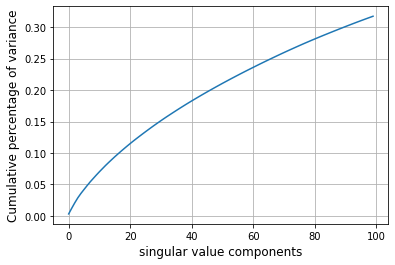

In [78]:
# Plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained)
plt.xlabel('singular value components', fontsize=12)
plt.ylabel('Cumulative percentage of variance', fontsize=12)
plt.grid()
plt.show()


## 35% variance is expalined using only 100 dimensions

In [79]:
# Our Final content Matrix:
latent_matrix_1_df = pd.DataFrame(latent_matrix, index=movies_f.title.tolist())
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),0.180040,-0.029722,0.179475,0.465403,-0.246522,-0.058467,0.024079,-0.125172,0.078756,0.013743,...,-0.054814,-0.071956,0.002817,-0.000950,-0.064500,0.041377,-0.008553,0.070346,-0.008664,0.067047
Jumanji (1995),0.141094,-0.039406,0.135546,0.068268,-0.009764,-0.009358,-0.008012,0.022965,-0.066246,0.039593,...,0.092014,0.010152,-0.017516,0.047160,0.058231,-0.016581,-0.014955,0.034295,0.004771,-0.032354
Grumpier Old Men (1995),0.066663,-0.027623,-0.033626,0.038313,0.050467,0.014015,0.015017,-0.019058,-0.032391,-0.001533,...,0.005802,-0.041076,-0.024136,-0.001700,-0.019697,-0.032463,0.048956,-0.003866,-0.000968,0.018295
Waiting to Exhale (1995),0.126630,-0.021244,-0.087329,0.072891,0.070760,0.023032,0.021088,-0.000584,-0.092995,0.035859,...,-0.042143,0.012819,0.034243,-0.010405,-0.043486,0.035520,-0.025988,0.051851,0.019523,-0.062368
Father of the Bride Part II (1995),0.130024,-0.046658,-0.058974,0.092080,0.077559,0.020384,0.033087,-0.006120,-0.046500,0.003842,...,0.006724,-0.151889,0.033963,0.031886,-0.004474,-0.022647,-0.070118,-0.020180,-0.006458,0.087285


In [80]:
latent_matrix_1_df.shape

(3138, 100)

 **Saving the content matrix to drive**

In [81]:
latent_matrix_1_df.to_csv(path+"Trained_content_matrix.csv")

## **Collaborative Filtering:** Using user ratings to create **item-item** based collaborative filtering Recommendation System

In [82]:
ratings_f.head()

,userId,movieId,rating,timestamp
960,11,1,4.5,2009-01-02 01:13:41
961,11,10,2.5,2009-01-02 01:15:59
962,11,19,3.5,2009-01-01 04:21:44
963,11,32,5.0,2009-01-01 04:11:35
964,11,39,4.5,2009-01-02 01:17:12


In [83]:
movies_f.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [84]:
# Creating item-user matrix

movie_user_mat = ratings_f.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,11,24,54,58,91,104,116,134,156,208,...,138270,138301,138307,138325,138382,138397,138406,138411,138437,138474
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.5,4.0,4.0,5.0,4.0,0.0,3.0,4.0,5.0,4.0,...,0.0,2.5,3.5,5.0,3.0,0.0,4.0,5.0,4.0,5.0
2,0.0,0.0,3.0,0.0,3.5,0.0,2.0,0.0,5.0,0.0,...,0.0,2.5,2.5,3.0,4.0,0.0,3.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


**Dimensionaly of dataset is very large**, so we need to do dimensionality reduction

**SVD:** for dimensionality reduction

In [85]:
# dimensionality reduction using SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix_2 = svd.fit_transform(movie_user_mat)

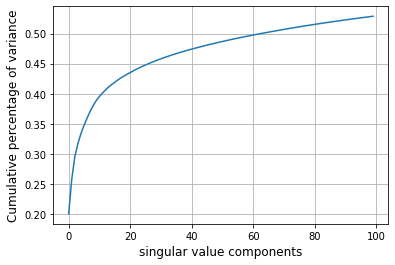

In [86]:
# Plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained)
plt.xlabel('singular value components', fontsize=12)
plt.ylabel('Cumulative percentage of variance', fontsize=12)
plt.grid()
plt.show()


## 55% variance is expalined using only 100 dimensions

In [87]:
# Our Final item-user Matrix:
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movies_f.title.tolist())
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),282.536686,6.816792,-18.585359,-9.663804,-10.364832,59.364696,17.815873,-15.457720,0.175336,8.821114,...,3.297067,-4.586727,0.027588,0.369162,-2.445215,4.962673,0.738252,5.908835,3.009192,1.034738
Jumanji (1995),160.335852,35.603744,-41.767050,-9.981951,-22.336570,27.036077,3.816849,-1.931654,-18.559959,21.741894,...,-4.077924,-3.217728,0.439263,-3.654022,-6.533838,-3.096823,-1.268108,-3.236967,1.986370,6.557879
Grumpier Old Men (1995),79.134740,-6.145754,-39.873735,-17.139839,-0.160426,-6.148283,-0.858873,-9.741734,10.495427,20.197649,...,1.867467,3.907384,-2.586700,-0.729132,-3.095919,3.055002,0.644858,2.867023,-0.452599,-1.525370
Waiting to Exhale (1995),20.404162,-14.381212,-6.370951,-14.540339,1.271769,-4.273144,-3.314943,-9.332595,-9.976461,2.039482,...,1.546884,-0.373134,1.579335,-0.920335,-1.695498,-3.283063,2.414414,1.376256,1.183534,-0.701068
Father of the Bride Part II (1995),65.954870,-2.622380,-33.489965,-31.520951,-2.698947,0.521843,-4.069042,-7.353642,-1.776220,16.673495,...,-1.100876,5.148838,-2.753069,-1.141302,1.035250,0.253215,-1.478890,-1.953285,-3.167468,-1.618703


In [88]:
latent_matrix_2_df.shape

(3138, 100)

**Saving the item-user matrix to drive**

In [89]:
latent_matrix_2_df.to_csv(path+"Trained_item_user_matrix.csv")

## **Recommend the movies:** using content, collaborative and Hybrid cosine Similarity

In [90]:
# Loading the Trained Model
latent_matrix_1_df = pd.read_csv(path+"Trained_content_matrix.csv").set_index('Unnamed: 0')
latent_matrix_2_df = pd.read_csv(path+"Trained_item_user_matrix.csv").set_index('Unnamed: 0')
movies_title_most_viewed = pd.read_csv(path+"movies_most_viewed.csv")

In [91]:
# Defining the function for recommending the movies

from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(title):

    # Take the latent vectors for a selected movie from both content and collaborative matrix
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # Calculate the similarity of the movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # An average measure of both content and collaborative
    hybrid = (score_1+score_2)/2.0

    # Form a DataFrame of similar movies
    dictDf = {'content-similarity': score_1, 'collaborative-similarity': score_2, 'hybrid': hybrid}
    similar = pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

    # Sort it on the basis of either: content, collaborative or hybrid
    # Here: hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    return similar.head(11)

### **Movies Title:** Sorted by most viewed

In [96]:
pd.set_option('display.max_rows', 100)
print("\nTotal Top Movies available: {}\n\n".format(movies_title_most_viewed.shape[0]))
movies_title_most_viewed


Total Top Movies available: 3138




,title,rating,rating_count
0,"Matrix, The (1999)",4.146633,6980
1,Forrest Gump (1994),3.844184,6912
2,Jurassic Park (1993),3.603232,6868
3,Back to the Future (1985),3.933168,6853
4,Pulp Fiction (1994),4.256348,6813
...,...,...,...
3133,Throne of Blood (Kumonosu jô) (1957),4.057000,500
3134,Scoop (2006),3.252000,500
3135,Peter's Friends (1992),3.126000,500
3136,Amazon Women on the Moon (1987),3.310000,500


### **Enter the Movie Title for recommendations**

Sorted on the basis of hybrid similarity

In [97]:
recommend_movies("Matrix, The (1999)")

,content-similarity,collaborative-similarity,hybrid
Unnamed: 0,,,
"Matrix, The (1999)",1.000000,1.000000,1.000000
"Matrix Reloaded, The (2003)",0.940407,0.884266,0.912337
"Matrix Revolutions, The (2003)",0.922372,0.828254,0.875313
Tron (1982),0.757748,0.816628,0.787188
Blade Runner (1982),0.613232,0.924286,0.768759
Dark City (1998),0.692010,0.838785,0.765397
Strange Days (1995),0.766951,0.738449,0.752700
Johnny Mnemonic (1995),0.738393,0.766488,0.752440
"Lawnmower Man, The (1992)",0.741880,0.727338,0.734609


In [98]:
recommend_movies("Silence of the Lambs, The (1991)")


,content-similarity,collaborative-similarity,hybrid
Unnamed: 0,,,
"Silence of the Lambs, The (1991)",1.000000,1.000000,1.000000
Hannibal (2001),0.900623,0.807284,0.853954
"Talented Mr. Ripley, The (1999)",0.732431,0.867314,0.799872
Seven (a.k.a. Se7en) (1995),0.525857,0.969927,0.747892
Manhunter (1986),0.846824,0.630852,0.738838
Red Dragon (2002),0.698415,0.763337,0.730876
Natural Born Killers (1994),0.582280,0.868009,0.725144
American Psycho (2000),0.618297,0.813970,0.716133
Summer of Sam (1999),0.757250,0.662766,0.710008


In [99]:
recommend_movies("Toy Story (1995)")

,content-similarity,collaborative-similarity,hybrid
Unnamed: 0,,,
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.982876,0.965952,0.974414
"Bug's Life, A (1998)",0.944598,0.953832,0.949215
"Monsters, Inc. (2001)",0.934854,0.909576,0.922215
Finding Nemo (2003),0.942199,0.882617,0.912408
Ice Age (2002),0.936568,0.811974,0.874271
Antz (1998),0.815173,0.894076,0.854625
"Incredibles, The (2004)",0.846114,0.846851,0.846483
Ratatouille (2007),0.940628,0.688081,0.814355


In [100]:
recommend_movies("Fight Club (1999)")

,content-similarity,collaborative-similarity,hybrid
Unnamed: 0,,,
Fight Club (1999),1.000000,1.000000,1.000000
American History X (1998),0.616426,0.957171,0.786799
Seven (a.k.a. Se7en) (1995),0.588814,0.968490,0.778652
Memento (2000),0.605548,0.947982,0.776765
Snatch (2000),0.605116,0.930494,0.767805
Primal Fear (1996),0.698159,0.716620,0.707390
"Sixth Sense, The (1999)",0.466981,0.940422,0.703702
"Game, The (1997)",0.493399,0.897177,0.695288
"Usual Suspects, The (1995)",0.456813,0.929909,0.693361


We can use the similarity information from item-item collaborative filtering to compute a rating prediction ***r[i][u]***, for an ***item(i)*** by a ***user(u)*** where the rating is missing. By taking a weighted average on the ratings of the top K nearest neighbours of item(i) which is already seen by user(u)